# Recommendation Systems: Amazon product reviews

The project builds a Recommendation Systems from the Amazon product reviews dataset. The dataset contains ratings of different electronic products and does not include information about the products or reviews to avoid bias while building the model. 

--------------
### Context: 
--------------

E-commerce websites like Amazon, Flipkart uses different recommendation models to provide personalized suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
### Objective:
----------------

The objective is to build a recommendation system to recommend products to customers based on their previous ratings for other products.

--------------
### Dataset:
--------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

In [ ]:
#!pip install surprise

### Importing Libraries

In [2]:
import warnings #Used to ignore the warning given as output of the code.
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

# from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.

from collections import defaultdict 
from sklearn.metrics import mean_squared_error

### Loading the original data

**NOTE: The original dataset is very large and has 78,24,482 observations**, making it computationally challenging to build a model. Moreover, many users have only rated a few products and also some products are rated by very few users (sparse system). Hence we can reduce the dataset by introducing some assumptions. Firstly, I will filter users who have given at least 50 ratings, and the products that have at least 5 ratings to build a more reliable system. The cell below have to be run on the first dataset only. I assume this has already been pre-processed and the filtered data is employed.

In [24]:
'''
#Import the data set
df = pd.read_csv('ratings_Electronics.csv', header=None) 
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp
df_copy = df.copy(deep=True) #Copying the data to another dataframe

# Get the column containing the users
users = df.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df.loc[~df.user_id.isin(remove_users)]

# Get the column containing the users
users = df.prod_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    
        
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = df.loc[~df.prod_id.isin(remove_users)]

#Export the data set for later use
df_final.to_csv('ratings_reduced.csv', index=False)         

'''

### Loading the filtered data

In [25]:
df_final = pd.read_csv('ratings_reduced.csv')

In [26]:
# see a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
0,A3LDPF5FMB782Z,1400501466,5.0
1,A1A5KUIIIHFF4U,1400501466,1.0
2,A2XIOXRRYX0KZY,1400501466,3.0
3,AW3LX47IHPFRL,1400501466,5.0
4,A1E3OB6QMBKRYZ,1400501466,1.0


### Exploratory Data Analysis

#### Shape of the data

In [ ]:
rows, columns = df_final.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  65290
No of columns:  3


**Obervations:**
- The database has 3 features and 65290 entries;

#### Data types

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Obervations:**
- There are 65290 observations and 3 columns in the data;
- Two columns are categorical and one colume is numeric data type;

#### Checking for missing values

In [ ]:
df_final.isnull().values.any()

False

**Obervations:**
- There are no missing values;

#### Summary Statistics

In [ ]:
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Obervations:**
- The mean rating is around 4.3;
- Most users assign a rating of 5;

#### Checking the rating distribution

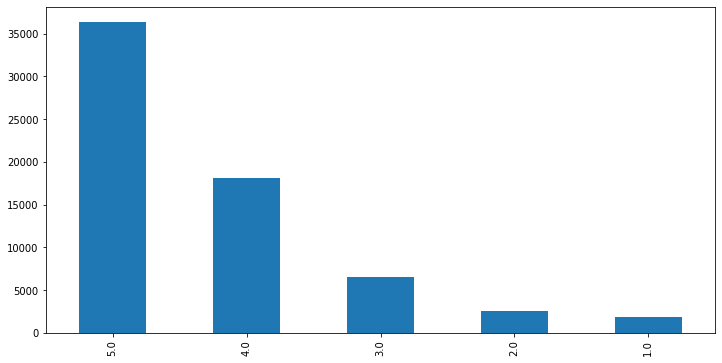

In [ ]:
plt.figure(figsize = (12,6))
df_final['rating'].value_counts().plot(kind='bar') # check this as well
plt.show()

**Observations:**

- The distribution is right-skewed with most ratings are 4 and 5;
- Most of the products are liked by users (ratings 4 and 5);


#### Checking the number of unique users and items in the dataset

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


- There are **1540 unique users and 5689 products** in the dataset

#### Users with most number of ratings

In [ ]:
# Top 10 users based on rating
most_rated = df_final.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

### Data preparation

In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 65290
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  5689


**Observations:**
- The size of the recommendation matrix is 1540*5689=8761060;
- The number of ratings is 65290, which accounts for about 0.7% of the total possible entries;
- As expected, we are dealing with a very sparse system;

### Rank Based Recommendation System

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
#Calculate the average rating for each product 
average_rating = df_final.groupby('prod_id').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_ratings, n, min_interaction=100):
   
    #Finding products with minimum number of interactions
    recommendations = final_ratings[final_ratings['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

#### Recommending top 5 products with 50 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### Recommending top 5 products with 100 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

The above system recommends the **top 5** products by using the popularity recommendation system. Next, I will build a recommendation system using collaborative filtering

### Collaborative Filtering Based Recommendation System

#### Building a baseline user user similarity based recommendation system

- Here we build a **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  

In [ ]:
#!pip install surprise

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing KFold cross-validation
from surprise.model_selection import KFold

#For implementing clustering-based recommendation system
from surprise import CoClustering

### Performance measures: Precision@k and Recall@ k

**Precision@k - fraction of recommended items that are relevant in `top k` predictions**. k is the number of recommendations to be provided to the user. 

**Recall@k - fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-Score@k - harmonic mean of Precision@k and Recall@k**. It is useful in cases in which **precision@k and recall@k both seem to be important**. 

### Useful functions

In [ ]:
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    #Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    #Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    #Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

Loading the `rating` dataset (a pandas dataframe) into a different format called `surprise.dataset.DatasetAutoFolds` (required by the library). The classes `Reader` and `Dataset` are employed for the purpose.

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

- We can build the first baseline similarity-based recommendation system using cosine similarity.
- KNNBasic is an algorithm used to find the desired similar items among a given set of items.
- A threshold of 3.5 and k value of 10 are assigned to compute precision and recall. 
- To minimize both the losses (precision and recall), F_1 score will be employed. 

### Building the user-user similarity-based recommendation system

In [ ]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

#Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Compute precision@k, recall@k, and f_1 score
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations:**
- The recall is approximately 86%, i.e., the algorithm recommends 86% of the relevant items;
- Out of all recommended items, roughly 86% are relevant (precision);
- F_1 score is also approx. 86%, which indicates most relevant items were recommended and most items recommended were relevant;

Let's now predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466` as shown below. Here the user has already interacted or watched the product with productId '1400501466'.

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

Below is the list of users who have not seen the product with product id "1400501466".

In [ ]:
df_final[df_final.prod_id=="1400501466"].user_id.unique()

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY',
       'AW3LX47IHPFRL', 'A1E3OB6QMBKRYZ', 'A19N3S7CBSU6O7'], dtype=object)

* User "A34BZM6S9L7QI4" has not seen a product with productId "1400501466".

Below we are predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not seen yet i.e. `prod_id=1400501466` 

In [ ]:
#predicting rating for a sample user with a non interacted product.
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

To optimize the system, the hyperparameters of KNNBasic algorithm are:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9717825078916046
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


#### Building the final model with the tuned hyperparameters from the grid search cross-validation

In [ ]:
# using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, random_state=1, verbose=False)

# training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10.
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


- After tuning hyperparameters, F_1 score of the tuned model is slightly better than the baseline model. The RMSE of the model has gone down as compared to the model before optimization.
- Hyperparameter tuning only slightly improves model performance.

In [ ]:
#Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466.
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 40.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=40, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
#Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
- For both predictions, there were not enough neighbors, which implies that the prediction is set to the global mean of all ratings;
- Predictions are not too far off from actual values.

## Identifying similar users to a given user (nearest neighbors)

Finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric

In [ ]:
sim_user_user_optimized.get_neighbors(0,5) #Here 0 is the inner id of the above user.

[6, 7, 17, 26, 32]

#### Implementing the recommendation algorithm based on optimized KNNBasic model

Implementing a function where the input parameters are - 

- data: a **rating** dataset
- user_id: a user id **against which we want the recommendations**
- top_n: the **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')
    
    # extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

#### Predicted top 5 products for userId="A3LDPF5FMB782Z" with similarity based recommendation system

In [ ]:
#Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [ ]:
#Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### Correcting the Ratings and Ranking the above products

The previous analysis did not account for the number of rating per each product. Nonetheless, for each product, the number of users who have seen that product is important since "rating_count" of a product is proportional to how much it is liked by users. Empirical evidence suggests that the likelihood of the product is directly proportional to the inverse of the square root of the 'rating_count' of the product.

In [ ]:
def ranking_products(recommendations, final_rating):
  # sort the products based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # merge with the recommended products to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  # rank the products based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # sort the products based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending=False)
  
  return ranked_products

In [ ]:
#Applying the ranking products function and sorting it based on corrected ratings. 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


### Item Item Similarity-based collaborative filtering recommendation systems 

In [ ]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

#KNN algorithm is used to find desired similar items.
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- The baseline model is giving a good F_1 score of ~84%. We will try to improve this later by using GridSearchCV by hyperparameters tuning.

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

Predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted yet i.e. `prod_id=1400501466` 

In [ ]:
#predicting rating for a sample user with a non interacted product.
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

### Hyperparameter tuning the item-item similarity-based model

In [ ]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9759754890749471
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


### Building the optimized item-item similarity-based model and comparing performance

In [ ]:
# using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options , k=30 , min_k=6 , random_state=1, verbose=False)

# training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score@k and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Observations:**
- The optimized model has a similar precision but a higher recall;
- F_1 score is almost unaltered;
- In general, the performance has not increased by much after tuning;
- RMSE has slightly decreased;


In [ ]:
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [ ]:
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Identifying similar users to a given user (nearest neighbors)

In [ ]:
sim_item_item_optimized.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

#### Predicted top 5 products for userId="A1A5KUIIIHFF4U" with similarity based recommendation system

In [ ]:
#Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
#Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [ ]:
#Applying the ranking products function and sorting it based on corrected ratings. 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a personalized recommendation system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. Latent features to find recommendations for each user.

#### Singular Value Decomposition (SVD)

SVD is used to compute the latent features from the user-item matrix. SVD requires a fully populated matrix (no missing values in the user-item matrix).

### Building the matrix factorization recommendation system

In [ ]:
# using SVD matrix factorization
svd = SVD(random_state=1)

# training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score@k, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observations:**
- SVD has decreased the error (RMSE) compared to item-item;
- Precision is slightly higher than item-item;
- Recall is identical to item-item;
- F_1 score is also very similar;

In [ ]:
#Making prediction.
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

Below we are predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted before i.e. `productId=1400501466`, as shown below - 

In [ ]:
#Making prediction. 
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

#### Improving matrix factorization based recommendation system by tuning its hyper-parameters

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward stochastic gradient descent:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Only three hyperparameters are selected for tuning:
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [ ]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting data
gs_.fit(data)

# best RMSE score
print(gs_.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8985815061051988
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


### Fitting the SVD model using the hyperparameters from GridSearchCV

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score@k, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Observations:**
- The optimization of SVD did not dramatically changed the performance of the model;
- Error, precision, recall and F_1 score are very similar;

Let's now predict a rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466` with the optimized model as shown below

In [ ]:
#Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466.
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [ ]:
#Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.216280997100113, details={'was_impossible': False})

**Observations:**
- The SVD predictions are very close to the actual values for both users on the same product;
- The SVD optimized does not improve predictions by much compared to non-optimized;



In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
#Get top 5 recommendations for user_id A2XIOXRRYX0KZY using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_final, "A2XIOXRRYX0KZY", 5, svd_optimized)

In [ ]:
#Ranking products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00IVPU6AA,14,4.851976,4.584715
2,B000JV9LUK,10,4.888310,4.572082
1,B0010Y414Q,11,4.860932,4.559421
3,B00AR95ESC,9,4.858811,4.525478
4,B005PQTYHE,7,4.842736,4.464772


### Conclusions

**Conclusions:**

**The case study has build recommendations system for an E-Commerce platform (Amazon) using similarity-based collaborative filtering algorithms user-user (UU), item-item (II) and model-based SVD method.**

Each algorithm has been fine-tuned by applying grid-searches on the hyperparameters and cross-validation.

The performance has been evaluated in terms of error, precision, recall and F_1 score. Considering F_1 score alone, the models' ranking in order of best performance are: UU-Opti (0.870), SVD & SVD-Opti (0.866), II-Opti (0.859), UU (0.856), II (0.845). 

Optimization has improved UU and II performance of approximately 1.6%, not SVD.

As a general remark, all models are fairily good and provide precision above 85%. Given the discrepancies might be caused by initialization and based on the results of recall, I suggest **employing the optimized user-user algorithm**. A further assessment could be based on **computing performance** of re-training and evaluation of each algorithm (building them through functions and using %timeit would be enough).